**The business problem is to develop an accurate sarcasm detection system for Reddit comments, leveraging a large dataset of sarcastic and non-sarcastic remarks. Sarcasm detection is crucial for enhancing user experience, as it enables more nuanced content moderation and sentiment analysis. Accurately identifying sarcastic comments can improve content recommendations and interactions by preventing misinterpretations and ensuring relevant user engagement. Additionally, understanding which features signal sarcasm can refine moderation processes and sentiment analysis tools, ultimately leading to a more positive and engaging online environment**

#  DATASET DESCRIPTION

** The Sarcasm on Reddit dataset, sourced from Kaggle, contains 1.3 million comments from the Reddit platform. This balanced dataset includes comments labeled as either sarcastic or non-sarcastic, allowing for the development and training of machine learning models to detect sarcasm. Each comment is accompanied by various metadata attributes such as the author, subreddit, score, ups, downs, date, timestamp, and the parent comment to provide context and enhance the model's understanding.

Attributes:
label: Indicates if the comment is sarcastic (1) or non-sarcastic (0).
comment: The actual text of the comment.
author: The username of the commenter.
subreddit: The subreddit where the comment was posted.
score: The net score of upvotes and downvotes.
ups: The number of upvotes.
downs: The number of downvotes.
date: The date the comment was posted.
created_utc: The timestamp when the comment was posted.
parent_comment: The text of the parent comment to which the comment was a response.

Examples:
You do know west teams play against west teams more than east teams right?
Damn I was hoping God was real
I can't wait until @potus starts a twitter war against Morning Joe. **

# INSTALLING AND IMPORTING NECESSARY LIBRARIES

In [2]:
# Install necessary libraries
!pip install transformers[torch]
!pip install accelerate -U
!pip install emoji
!pip install scikit-learn

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#IMPORTING THE DATASET
df = pd.read_csv("C:\\Users\\guded\\OneDrive\\Desktop\\train-balanced-sarcasm.csv")

# DATA PREPROCESSING

In [12]:
df.head()   #FIRST 5 ROWS OF THE DATASET

,label,comment,score,ups,downs,parent_comment
0,0,NC and NH.,2.0,-1.0,-1.0,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,-4.0,-1.0,-1.0,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",3.0,3.0,0.0,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",-8.0,-1.0,-1.0,deadass don't kill my buzz
4,0,I could use one of those tools.,6.0,-1.0,-1.0,Yep can confirm I saw the tool they use for th...


In [13]:
df.shape #SHAPE OF THE DATASET

(1010822, 6)

In [ ]:
df = df.drop('author',axis = 1)
df = df.drop('subreddit', axis=1)
df = df.drop('date', axis=1)
df = df.drop('created_utc', axis=1)
df.head()                                 #DROP THE UNWANTED FIELDS

In [ ]:
df.isnull()            # CHECKING THE NULL VALUES

In [ ]:
df.isnull().sum()      # TOTAL NUMBER OF NULL VALUES

In [15]:
df.count()       #COUNT OF THE FIELDS

label             1010822
comment           1010768
score             1010821
ups               1010821
downs             1010821
parent_comment    1010821
dtype: int64

In [16]:
df.dropna(inplace = True)
df.head()                #REMOVING THE NULL VALUES

,label,comment,score,ups,downs,parent_comment
0,0,NC and NH.,2.0,-1.0,-1.0,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,-4.0,-1.0,-1.0,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",3.0,3.0,0.0,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",-8.0,-1.0,-1.0,deadass don't kill my buzz
4,0,I could use one of those tools.,6.0,-1.0,-1.0,Yep can confirm I saw the tool they use for th...


In [17]:
df.duplicated().sum()  #CHECKING FOR THE DUPLICATE VALUES

315

In [18]:
df.drop_duplicates(inplace = True)   #DROPPING THE DUPLICATE VALUES

In [20]:
df.duplicated().sum()

0

In [21]:
df.isnull().sum()

label             0
comment           0
score             0
ups               0
downs             0
parent_comment    0
dtype: int64

In [22]:
df.describe()   #DESCRIBING THE DATASET

,score,ups,downs
count,1.010453e+06,1.010453e+06,1.010453e+06
mean,6.887710e+00,5.500541e+00,-1.458623e-01
std,4.835166e+01,4.128046e+01,3.529683e-01
min,-5.070000e+02,-5.070000e+02,-1.000000e+00
25%,1.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,1.000000e+00,0.000000e+00
75%,4.000000e+00,3.000000e+00,0.000000e+00
max,9.070000e+03,5.163000e+03,0.000000e+00


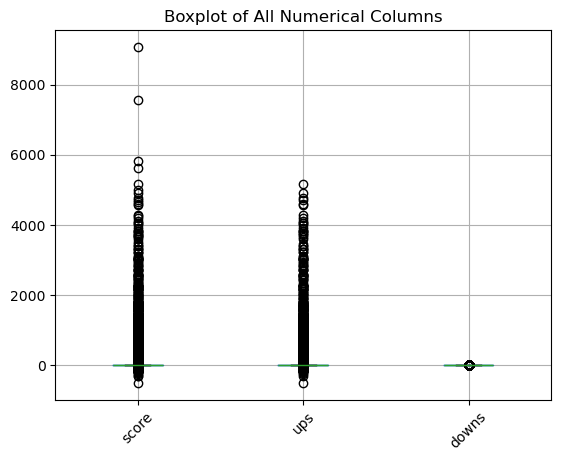

In [24]:
df.boxplot()
plt.title('Boxplot of All Numerical Columns')
plt.xticks(rotation=45)
plt.show()

# DATA CLEANING

In [56]:
# Define text preprocessing functions
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

In [57]:
def decontracted(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def remove_html(text):
    return re.sub(r'<.*?>', "", text)

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def remove_emoji(text):
    return emoji.demojize(text)

def preprocess_text(text):
    text = decontracted(text)
    text = remove_html(text)
    text = remove_punctuation(text)
    text = remove_numbers(text)
    text = remove_emoji(text)
    text = remove_stopwords(text)
    return text


In [58]:
# Apply preprocessing
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df['cleaned_text'] = df['comment'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# DATA BALANCING

In [59]:
# **Data Balancing: Oversample the minority class**
sarcastic = df[df['label'] == 1]
not_sarcastic = df[df['label'] == 0]
sarcastic_oversampled = sarcastic.sample(len(not_sarcastic), replace=True, random_state=42)
df_balanced = pd.concat([not_sarcastic, sarcastic_oversampled])

In [61]:
# Split dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(df_balanced['cleaned_text'], df_balanced['label'], test_size=0.2, random_state=42)

# DEEP LEARNING MODEL (BERT)

In [65]:
# Tokenize using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)


In [66]:
# Convert to PyTorch Dataset
class SarcasmDatasetWithW2V(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, w2v_vectors):
        self.encodings = encodings
        self.labels = labels
        self.w2v_vectors = w2v_vectors

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        item['w2v_vectors'] = torch.tensor(self.w2v_vectors[idx], dtype=torch.float32)
        return item

    def __len__(self):
        return len(self.labels)

In [67]:
train_dataset = SarcasmDatasetWithW2V(train_encodings, train_labels.tolist(), train_w2v_vectors)
val_dataset = SarcasmDatasetWithW2V(val_encodings, val_labels.tolist(), val_w2v_vectors)

In [ ]:
# Load BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

In [72]:
# **Define training arguments with increased epochs and learning rate scheduler**
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,  
    per_device_train_batch_size=32,  # Adjust batch size
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=2e-5,  # Adjust learning rate
)

In [73]:
from transformers import get_linear_schedule_with_warmup

In [74]:
# Define the trainer with a learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=500, num_training_steps=training_args.num_train_epochs * len(train_dataset))

In [75]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, scheduler)
)


In [76]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.680400,0.635010,0.692090,0.660964,0.719120,0.611511
2,0.497100,0.462596,0.806497,0.794603,0.829421,0.762590
3,0.304300,0.332310,0.868644,0.873124,0.830091,0.920863
4,0.185200,0.196651,0.927966,0.928969,0.900135,0.959712
5,0.086900,0.205336,0.942090,0.942976,0.912517,0.975540


TrainOutput(global_step=885, training_loss=0.3948352714042879, metrics={'train_runtime': 351.1729, 'train_samples_per_second': 80.616, 'train_steps_per_second': 2.52, 'total_flos': 800150524899000.0, 'train_loss': 0.3948352714042879, 'epoch': 5.0})

In [77]:
# Evaluate the model
eval_results = trainer.evaluate()

In [78]:
# Make predictions
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=1)

In [79]:
# Compute confusion matrix
conf_matrix = confusion_matrix(val_labels, preds)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[656  65]
 [ 17 678]]


In [80]:
# **Print classification report with zero_division=1**
class_report = classification_report(val_labels, preds, target_names=['Not Sarcastic', 'Sarcastic'], zero_division=1)
print("Classification Report:")
print(class_report)

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.97      0.91      0.94       721
    Sarcastic       0.91      0.98      0.94       695

     accuracy                           0.94      1416
    macro avg       0.94      0.94      0.94      1416
 weighted avg       0.94      0.94      0.94      1416



In [81]:
# Compute accuracy
accuracy = accuracy_score(val_labels, preds)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9421


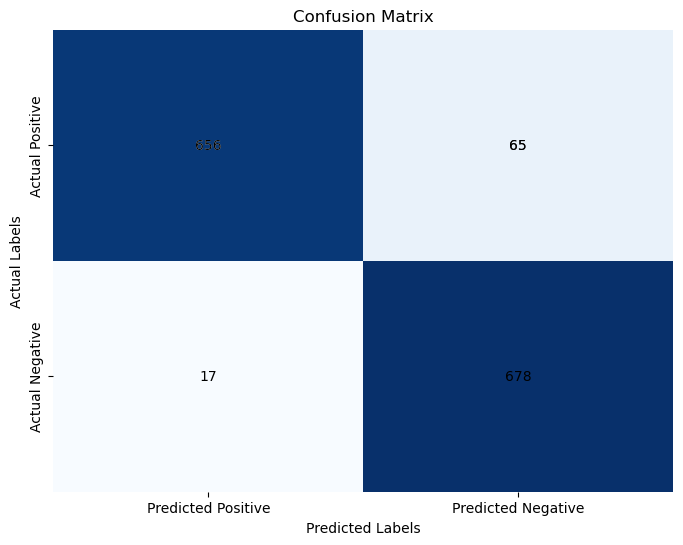

In [21]:
# Plot confusion matrix as a diagram
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()